In [1]:
import os
import re
import nrrd
import scipy 

import numpy as np
import pandas as pd

from sklearn.neighbors import DistanceMetric

from sklearn.cluster import KMeans
from resizeimage import resizeimage
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.neighbors import DistanceMetric

from ioutil import relative_paths

#from skimage.measure import compare_ssim as ssim

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams, cycler
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
patient_id = np.load('./../../data_source/patient_id.npy')

In [3]:
paths_to_ct = relative_paths('./../../data_source/images/ct_nrrd', target_format='nrrd')
paths_to_pet = relative_paths('./../../data_source/images/pet_nrrd', target_format='nrrd')
paths_to_mask = relative_paths('./../../data_source/images/masks_nrrd', target_format='nrrd')

ct = {}
pet = {}
mask = {}
ct_cropped = {}
pet_cropped = {}

for num, path_to_ct in enumerate(paths_to_ct):
    
    ct_image, _ = nrrd.read(path_to_ct)
    ct[path_to_ct] = ct_image

    pet_image, _ = nrrd.read(paths_to_pet[num])
    pet[paths_to_pet[num]] = pet_image
    
    mask_image, _ = nrrd.read(paths_to_mask[num])
    mask[paths_to_mask[num]] = mask_image
    
    ct_cropped[path_to_ct] = ct[path_to_ct] * mask_image

    pet_cropped[paths_to_pet[num]] = pet[paths_to_pet[num]] * mask_image

# CT & PET GL Statistics

In [4]:
def gl_statistics(image):
    
    _image = np.copy(image)
    _image[image == 0] = np.nan

    return {
        'gl_mean': np.nanmean(_image),
        'gl_median': np.nanmedian(_image),
        'gl_min': np.nanmin(_image),
        'gl_max': np.nanmax(_image),
    }

In [5]:
# Complete image statistics. 
ct_stats, pet_stats = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet.values(), ct.values())):
  
    pet_stats[num] = gl_statistics(pet_image)
    ct_stats[num] = gl_statistics(ct_image)
    
# Cropped image statistics.
ct_cropped_stats, pet_cropped_stats = {}, {}
for num, (cropped_pet_image, cropped_ct_image) in enumerate(zip(pet_cropped.values(), ct_cropped.values())):
    
    pet_cropped_stats[num] = gl_statistics(cropped_pet_image)
    ct_cropped_stats[num] = gl_statistics(cropped_ct_image)
    
    
df_ct_stats = pd.DataFrame(ct_stats)
df_ct_cropped_stats = pd.DataFrame(ct_cropped_stats)

df_pet_stats = pd.DataFrame(pet_stats)
df_pet_cropped_stats = pd.DataFrame(pet_cropped_stats)

df_ct_stats.columns = patient_id
df_ct_cropped_stats.columns = patient_id

df_pet_stats.columns = patient_id
df_pet_cropped_stats.columns = patient_id

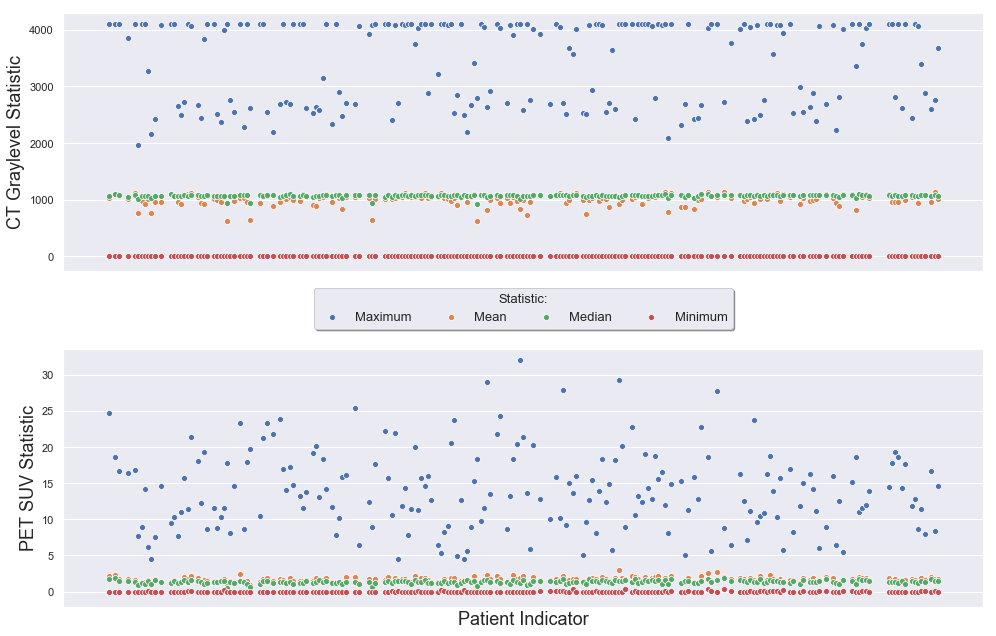

In [6]:
# Observations: 
# * Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# * The difference between average max in the complete and cropped image illustrates the significant amount of 
#   artifacts in each image. 

# Plot CT image and tumor GL stats. 
sns.set()
#rcParams['axes.prop_cycle'] = cycler(color=['g', 'b', 'y'])
fig, (ct_axis, pet_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Maximum', 'Mean', 'Median', 'Minimum']
for num, (ct_row_label, pet_row_label) in enumerate(zip(df_ct_stats.T, df_pet_stats.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_stats.columns.values), 
        y=np.squeeze(df_pet_stats.loc[pet_row_label, :].values),
        ax=pet_axis,
        cmap='muted',
        label=labels[num]
    )
    sns.scatterplot(
        x=np.squeeze(df_ct_stats.columns.values), 
        y=np.squeeze(df_ct_stats.loc[ct_row_label, :].values),
        ax=ct_axis,
        cmap='muted',
    )
pet_axis.legend(
    title='Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
pet_axis.set_ylabel('PET SUV Statistic', fontsize=18)
ct_axis.set_ylabel('CT Graylevel Statistic', fontsize=18)

plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './pet_ct_img_value_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

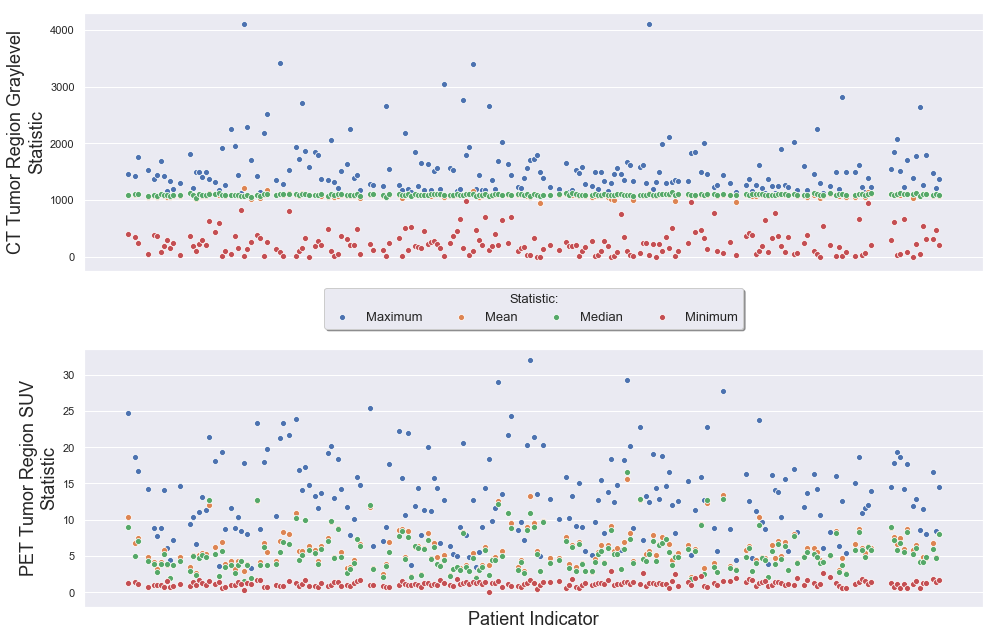

In [7]:
# Observations: 
# * Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# * The difference between average max in the complete and cropped image illustrates the significant amount of 
#   artifacts in each image. 

# Plot CT image and tumor GL stats. 
sns.set()
#rcParams['axes.prop_cycle'] = cycler(color=['g', 'b', 'y'])
fig, (ct_cropped_axis, pet_cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Maximum', 'Mean', 'Median', 'Minimum']
for num, (ct_cropped_row_label, pet_cropped_row_label) in enumerate(zip(df_ct_cropped_stats.T, df_pet_cropped_stats.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_cropped_stats.columns.values), 
        y=np.squeeze(df_pet_cropped_stats.loc[pet_cropped_row_label, :].values),
        ax=pet_cropped_axis,
        cmap='muted',
        label=labels[num]
    )
    sns.scatterplot(
        x=np.squeeze(df_ct_cropped_stats.columns.values), 
        y=np.squeeze(df_ct_cropped_stats.loc[ct_cropped_row_label, :].values),
        ax=ct_cropped_axis,
        cmap='muted',
    )
pet_cropped_axis.legend(
    title='Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
pet_cropped_axis.set_ylabel('PET Tumor Region SUV\nStatistic', fontsize=18)
ct_cropped_axis.set_ylabel('CT Tumor Region Graylevel\nStatistic', fontsize=18)

plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './cropped_pet_ct_img_value_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Clustering of CT Max GL Statistic

In [8]:
sns.set()

euc_dist = DistanceMetric.get_metric('euclidean')
euc_dist_mat = euc_dist.pairwise(df_ct_stats.loc['gl_max', :].values[:, np.newaxis])

In [9]:
y_pred_kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(euc_dist_mat)
gl_max_thresh_kmeans = np.max(df_ct_stats.loc['gl_max', :].values[y_pred_kmeans==1])
print(gl_max_thresh_kmeans)

# From scikit-learn: One can think of mixture models as generalizing k-means clustering to incorporate 
# information about the covariance structure of the data as well as the centers of the latent Gaussians.

# https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
y_pred_gmm = GaussianMixture(n_components=2, random_state=0).fit_predict(euc_dist_mat)
gl_max_thresh_gmm = np.max(df_ct_stats.loc['gl_max', :].values[y_pred_gmm==1])
print(gl_max_thresh_gmm)

3279.2492561226827
3279.2492561226827


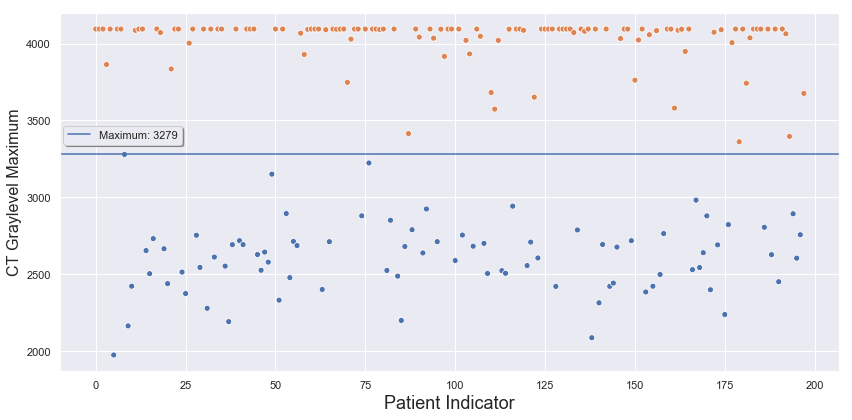

In [10]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    np.arange(198),
    np.squeeze(df_ct_stats.loc['gl_max', :].values),
    hue=y_pred_kmeans==0,
    legend=False,
)
plt.ylabel('CT Graylevel Maximum', fontsize=16)
plt.xlabel('Patient Indicator', fontsize=18)
plt.axhline(y=gl_max_thresh_kmeans)
plt.legend(
    [f'Maximum: {int(gl_max_thresh_kmeans)}'],
    loc='upper center', bbox_to_anchor=(0.08, 0.7),
    ncol=1, fancybox=True, shadow=True
)
plt.savefig(
    './kmeans_clustering_ct_max',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)
plt.tight_layout()

# Examples max cluster

In [11]:
# NOTE: 
# * None of the images with extreme statistics is among the images removed due to too many 
#   corrupted slices.

# 38: The majority of the tumor contains jaw bone, teeths and streaking artifacts.
# 49: Some slices with streak artifacts.
# 100: Some slices with streak artifacts.
# 109: Some slices with streak artifacts.
# 164: Some slices with streak artifacts.
i = df_ct_cropped_stats.loc['gl_max', :].values >= gl_max_thresh_gmm
df_ct_cropped_stats.loc['gl_max', i]

38     4094.677572
49     3413.780957
109    3395.597620
164    4094.937514
Name: gl_max, dtype: float64

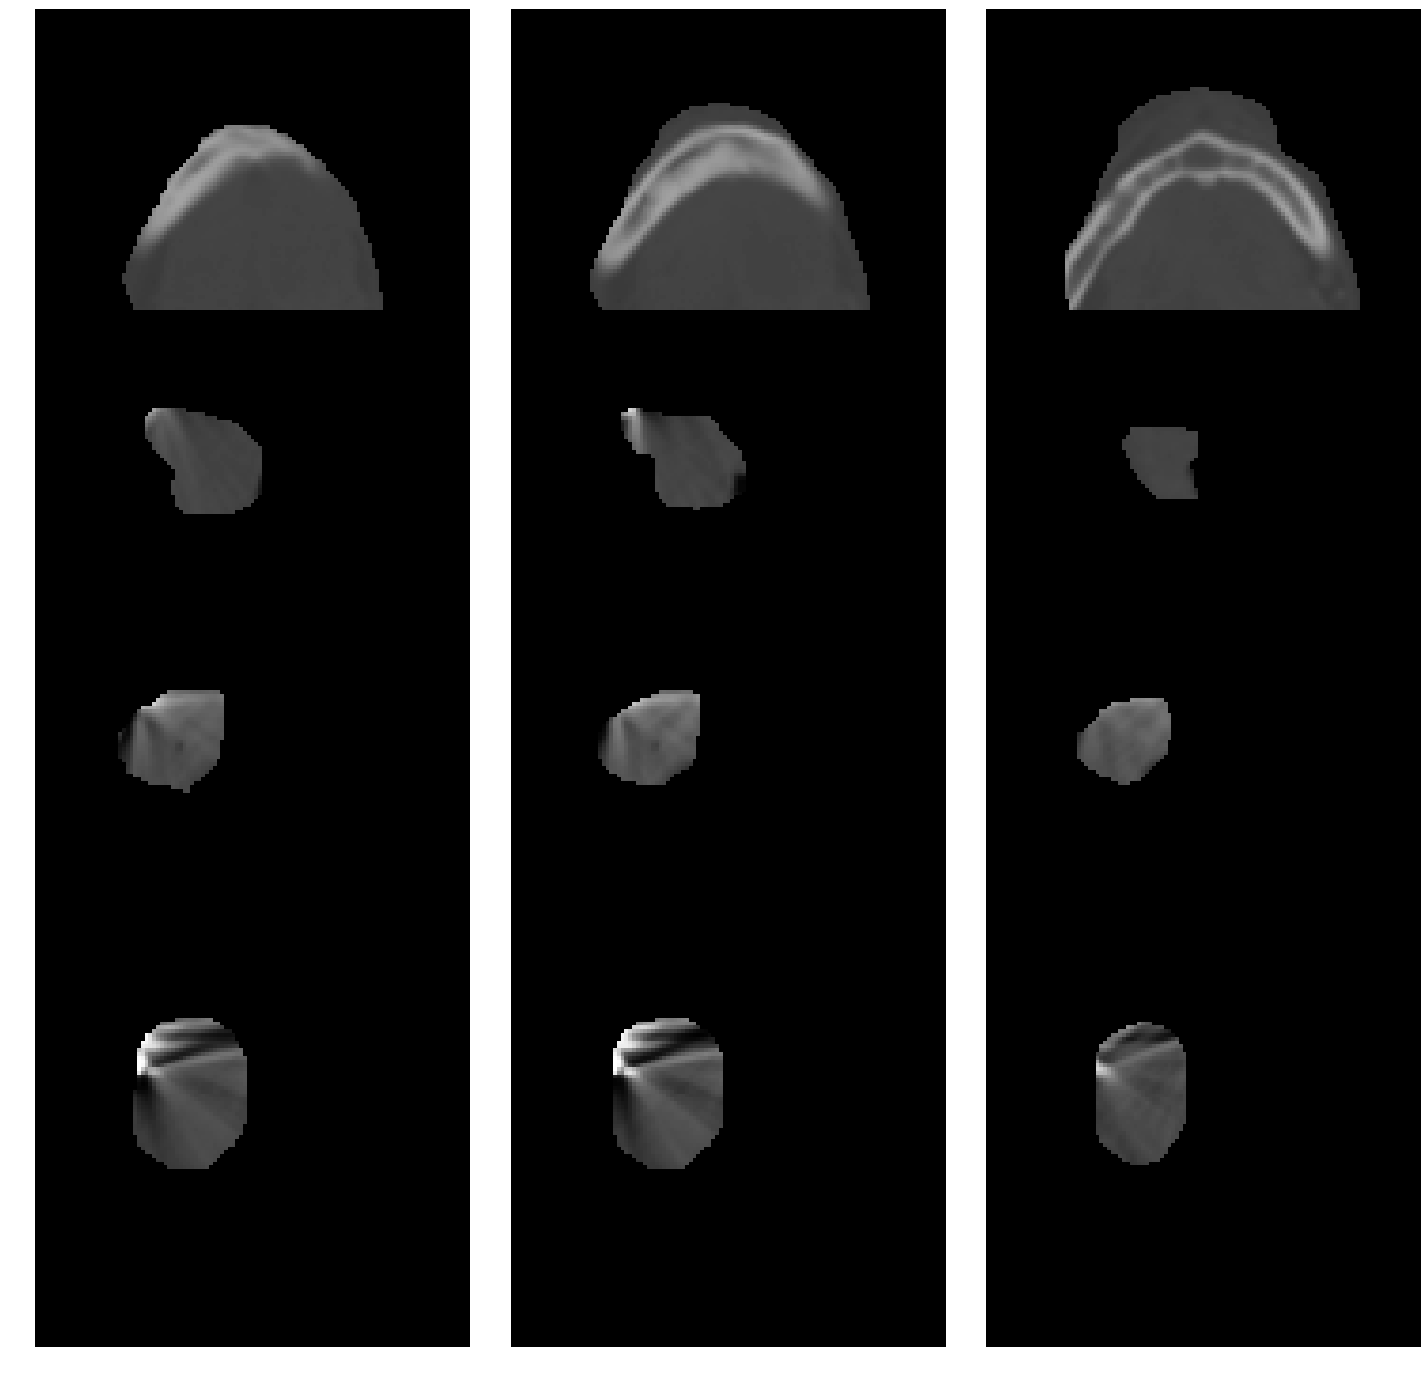

In [12]:
# Some of the artifacts found in the CT scans of the patients exceeding 3027 GL intensity.

images_to_plot = [
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'][:, :, 47],
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'][:, :, 50],
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'][:, :, 57],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'][:, :, 47],
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'][:, :, 50],
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'][:, :, 57],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 47],
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 48],
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 50],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'][:, :, 58],
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'][:, :, 59],
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'][:, :, 61],
]
new_rows, new_cols = 115, 115
fig, axes = plt.subplots(nrows=int(len(images_to_plot) / 3), ncols=3, figsize=(20, 20))
for num, axis in enumerate(axes.ravel()):
    
    rows, cols = np.shape(images_to_plot[num])
    new_image = np.zeros((new_rows, new_cols))
    new_image[:rows, :cols] = images_to_plot[num][:new_rows, :new_cols]

    axis.imshow(
        new_image[:, :],
        cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12
    )
    vmin=np.min(images_to_plot[num]),
    vmax=np.max(images_to_plot[num])
    axis.axis('off')   
plt.subplots_adjust(hspace=-0.7)
plt.tight_layout()

# Histograms examples max cluster

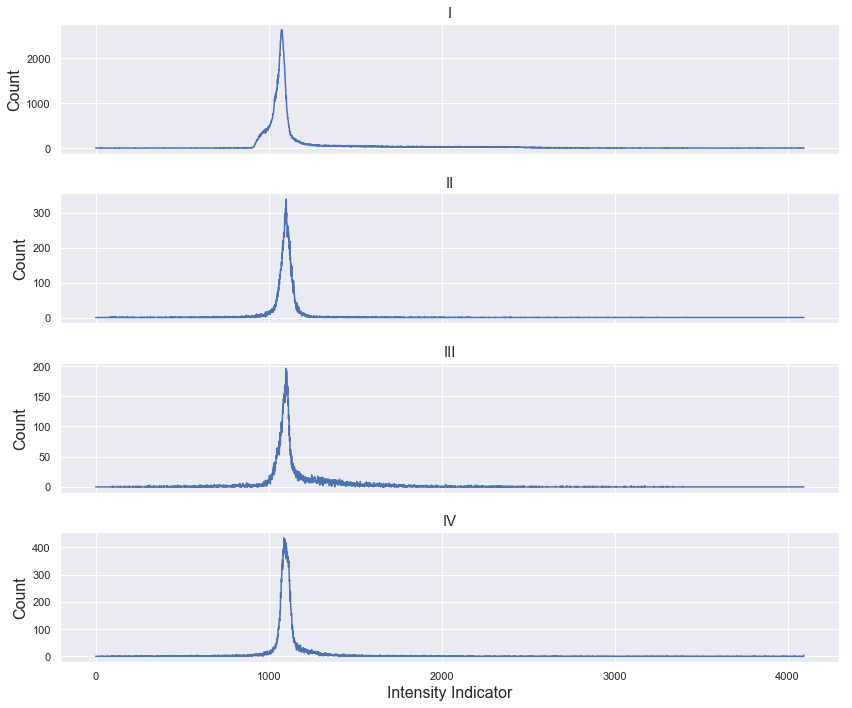

In [13]:
# Observations:
# * Histogram resembles dirac delta function (for not so small a param, see wiki).
imgs = [
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'],
]
# Try bins: 32, 64, 128 as in feature extraction.
fig, axes = plt.subplots(nrows=len(imgs), figsize=(12, 10), sharex=True)
titles = ['I', 'II', 'III', 'IV', 'V']
for num, axis in enumerate(axes.ravel()):
    img = imgs[num]
    # NOTE: Skip background voxels.
    hist, _ = np.histogram(np.squeeze(img[img != 0].ravel()), bins=np.linspace(0, 2**12, 2**12))
    axes[num].set_title(titles[num], fontsize=15)
    axes[num].plot(np.arange(np.size(hist)), np.squeeze(hist))
    axes[num].set_ylabel('Count', fontsize=16)
    
plt.xlabel('Intensity Indicator', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Examples min cluster

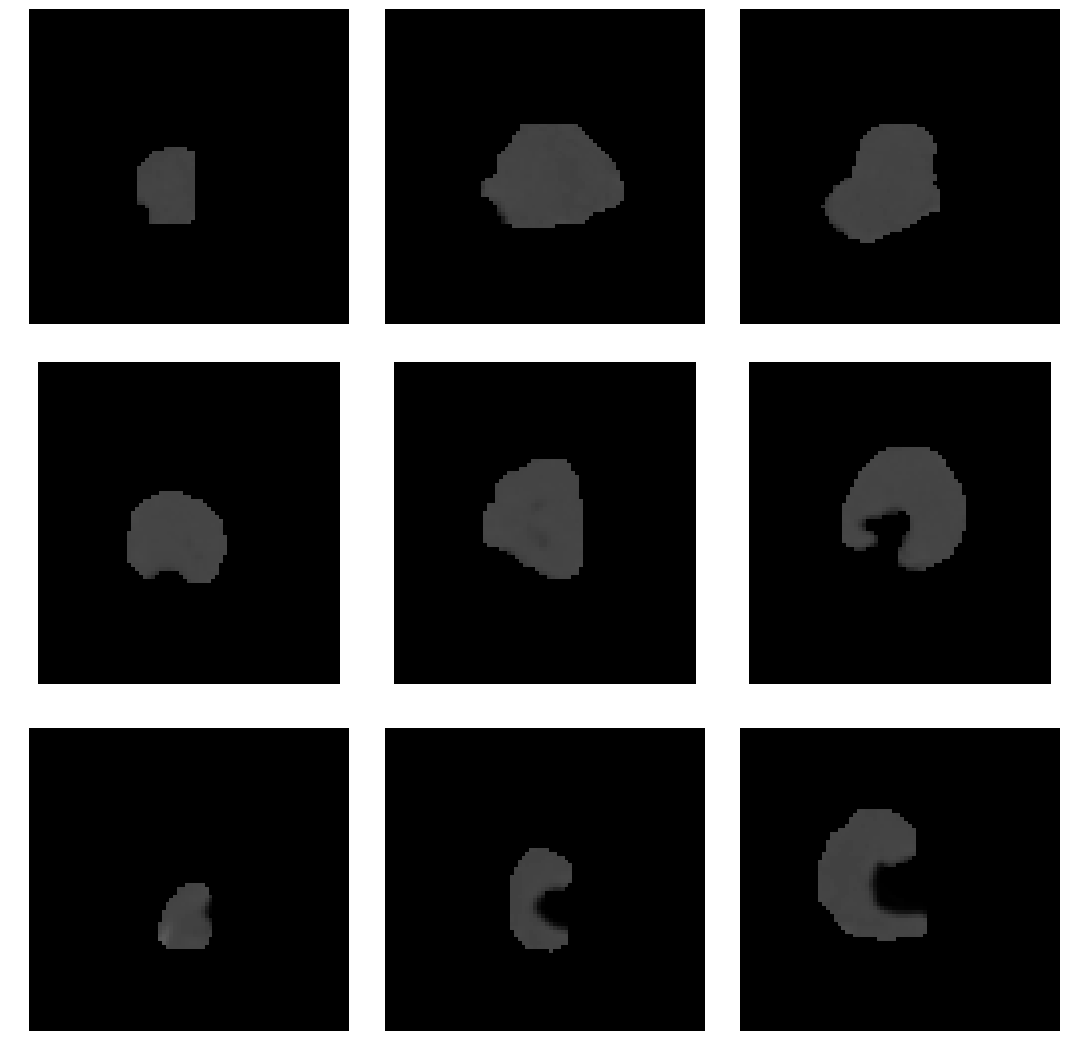

In [14]:
# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# Selected slices with max(I) < 3000.

images_to_plot = [
    ct_cropped['./../../data_source/images/ct_nrrd/P002CT.nrrd'][:, :, 21],
    ct_cropped['./../../data_source/images/ct_nrrd/P002CT.nrrd'][:, :, 26],
    ct_cropped['./../../data_source/images/ct_nrrd/P002CT.nrrd'][:, :, 32],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P077CT.nrrd'][:, :, 25],
    ct_cropped['./../../data_source/images/ct_nrrd/P077CT.nrrd'][:, :, 35],
    ct_cropped['./../../data_source/images/ct_nrrd/P077CT.nrrd'][:, :, 45],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P130CT.nrrd'][:, :, 25],
    ct_cropped['./../../data_source/images/ct_nrrd/P130CT.nrrd'][:, :, 37],
    ct_cropped['./../../data_source/images/ct_nrrd/P130CT.nrrd'][:, :, 55],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P182CT.nrrd'][:, :, 31],
    ct_cropped['./../../data_source/images/ct_nrrd/P182CT.nrrd'][:, :, 41],
    ct_cropped['./../../data_source/images/ct_nrrd/P182CT.nrrd'][:, :, 51],
]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.patch.set_facecolor('white')
for num, axis in enumerate(axes.ravel()):
    axis.imshow(
        images_to_plot[num],
        cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12,
    ),
    axis.axis('off')   
#plt.subplots_adjust(wspace=0, hspace=-0.8)
plt.tight_layout()

# Examples min cluster

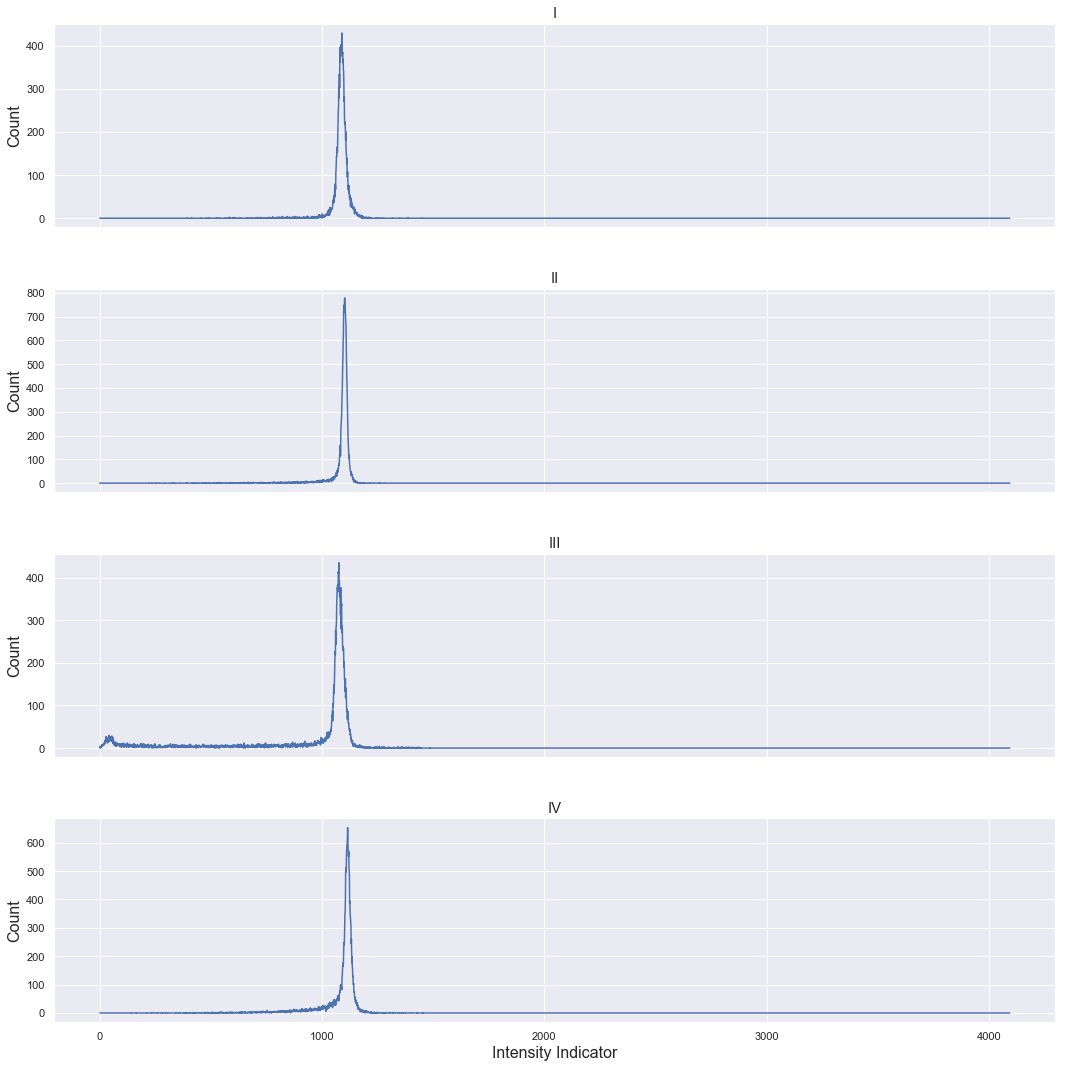

In [15]:
# Observations:
# * Histogram resembles dirac delta function (for not so small a param, see wiki).

imgs = [
    ct_cropped['./../../data_source/images/ct_nrrd/P002CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P077CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P130CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P182CT.nrrd'],
]
# Try bins: 32, 64, 128 as in feature extraction.
fig, axes = plt.subplots(nrows=len(imgs), figsize=(15, 15), sharex=True)
titles = ['I', 'II', 'III', 'IV']
for num, axis in enumerate(axes.ravel()):
    hist, _ = np.histogram(np.squeeze(imgs[num].ravel()), bins=np.linspace(0, 2**12, 2**12))
    # NOTE: Skip background voxels.
    hist = hist[1:]
    axes[num].set_title(titles[num], fontsize=15)
    axes[num].plot(np.arange(np.size(hist)), np.squeeze(hist))
    axes[num].set_ylabel('Count', fontsize=16)
    
plt.xlabel('Intensity Indicator', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# CT Outliers by IBSI Definition

In [16]:
ct_cropped_std = []
for ct_image in ct_cropped.values():
    ct_cropped_std.append(np.std(ct_image[ct_image != 0]))
    
ct_cropped_std = np.array(ct_cropped_std)

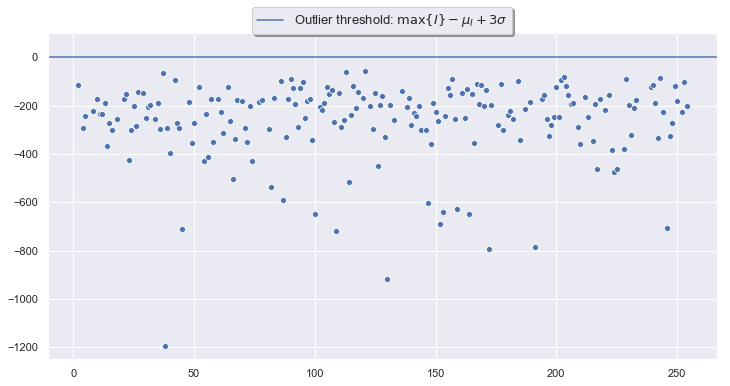

In [17]:
n = 3

df_ct_cropped_max = df_pet_stats.loc['gl_max', :].values
outliers = np.mean(df_ct_cropped_max) + n * ct_cropped_std

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=np.squeeze(df_pet_stats.columns.values), 
    y=np.squeeze(df_ct_cropped_max) - outliers,
)
plt.axhline(y=0)
plt.ylim([-1250, 100])
plt.legend(
    [r'Outlier threshold: $\max \left \{ I \right \} - \mu_{I} + 3 \sigma$'],
    title_fontsize=14,
    fontsize=13,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.1),
    ncol=1, 
    fancybox=True, 
    shadow=True
)